In [1]:
using ITensors, ITensorMPS, Optim, LinearAlgebra, Printf, Random, Plots
Random.seed!(123)
include("src/QuantumResource1D.jl")
include("src/HL_module.jl")

N = 5

5

In [ ]:
g_values = range(-1.0, 1.0, 5)
all_params, all_costs, all_qr = [], [], []
all_X_exp, all_O_exp, all_ZZ_exp = [], [], []
fidelity_ghz_vals, fidelity_cluster_vals = [], []
λ_vals, delta_E_vals, H_params, HL_fidelities = [], [], [], []
all_O_HL_exp, all_ZZ_HL_exp = [], []

for g in g_values
    println("\n=== g = $g ===")

    qr_g = QR1D.QuantumResource1D(N)
    GHZ_wf, params_GHZ, name_GHZ = QR1D.generate_GHZ_state(qr_g)
    cluster_wf, params_cluster, name_cluster = QR1D.generate_cluster_state(qr_g)
    QR1D.AddQR(qr_g, GHZ_wf, params_GHZ, name_GHZ)
    QR1D.AddQR(qr_g, cluster_wf, params_cluster, name_cluster);

    θ_g, cost_g = QR1D.optimize_circuit_QR(qr_g, g)
    psi_g = QR1D.apply_ladder_circuit(qr_g, θ_g)

    hl = HL1D.HamiltonianLearner(psi_g)
    λ_min, v_min = HL1D.LearnHamiltonian_corr_mat(hl)

    push!(all_params, θ_g)
    push!(all_costs, cost_g)
    push!(all_qr, qr_g)
    push!(all_X_exp, real(inner(psi_g', qr_g.aux_ops[1], psi_g)))
    push!(all_O_exp, real(inner(psi_g', qr_g.aux_ops[2], psi_g)))
    push!(all_ZZ_exp, real(inner(psi_g', qr_g.aux_ops[3], psi_g)))
    push!(fidelity_ghz_vals, abs2(inner(psi_g, GHZ_wf)))
    push!(fidelity_cluster_vals, abs2(inner(psi_g, cluster_wf)))

    push!(λ_vals, λ_min)
    push!(H_params, v_min)
    push!(delta_E_vals, hl.E_psi - hl.E_GS)
    push!(HL_fidelities, hl.Fidelity)

    push!(all_O_HL_exp, real(inner(hl.ψ_GS', qr_g.aux_ops[2], hl.ψ_GS)))
    push!(all_ZZ_HL_exp, real(inner(hl.ψ_GS', qr_g.aux_ops[3], hl.ψ_GS)))
end



=== g = -1.0 ===
Fidelity wrt to GHZ = 1.0
Fidelity wrt to cluster state = 1.0
Optimizing for g = -1.0...
Iter     Function value   Gradient norm 
     0     1.917353e-32     1.167199e-11
 * time: 0.015822887420654297
Optimizing for g = -1.0...
Iter     Function value   Gradient norm 
     0    -1.000000e+00     4.308552e-09
 * time: 6.198883056640625e-5


┌ Warning: Calling `inner(x::MPS, A::MPO, y::MPS)` where the site indices of the `MPS`
│ `x` and the `MPS` resulting from contracting `MPO` `A` with `MPS` `y` don't
│ match is deprecated as of ITensors v0.3 and will result in an error in ITensors
│ v0.4. The most common cause of this is something like the following:
│ 
│ ```julia
│ s = siteinds("S=1/2")
│ psi = random_mps(s)
│ H = MPO(s, "Id")
│ inner(psi, H, psi)
│ ```
│ 
│ `psi` has the Index structure `-s-(psi)` and `H` has the Index structure
│ `-s'-(H)-s-`, so the Index structure of would be `(dag(psi)-s- -s'-(H)-s-(psi)`
│  unless the prime levels were fixed. Previously we tried fixing the prime level
│   in situations like this, but we will no longer be doing that going forward.
│ 
│ There are a few ways to fix this. You can simply change:
│ 
│ ```julia
│ inner(psi, H, psi)
│ ```
│ 
│ to:
│ 
│ ```julia
│ inner(psi', H, psi)
│ ```
│ 
│ in which case the Index structure will be `(dag(psi)-s'-(H)-s-(psi)`.
│ 
│ Alternatively, you c

Degeneracy = 4
After sweep 1 energy=-2.8847294954317753  maxlinkdim=2 maxerr=3.83E-16 time=4.662
After sweep 2 energy=-2.884729495431777  maxlinkdim=2 maxerr=3.62E-16 time=0.003
After sweep 3 energy=-2.8847294954317797  maxlinkdim=2 maxerr=3.81E-16 time=0.002
After sweep 4 energy=-2.884729495431777  maxlinkdim=2 maxerr=4.54E-16 time=0.002
After sweep 5 energy=-2.8847294954317797  maxlinkdim=2 maxerr=4.02E-16 time=0.002
After sweep 6 energy=-2.8847294954317775  maxlinkdim=2 maxerr=3.79E-16 time=0.003
After sweep 7 energy=-2.884729495431779  maxlinkdim=2 maxerr=4.26E-16 time=0.005
After sweep 8 energy=-2.8847294954317784  maxlinkdim=2 maxerr=3.90E-16 time=0.002
Fidelity = 0.9999999999999944
GS energy = -2.8847294954317784

=== g = -0.5 ===
Fidelity wrt to GHZ = 1.0
Fidelity wrt to cluster state = 1.0
Optimizing for g = -0.5...
Iter     Function value   Gradient norm 
     0    -2.500000e-01     2.062605e-11
 * time: 6.985664367675781e-5
Optimizing for g = -0.5...
Iter     Function value 

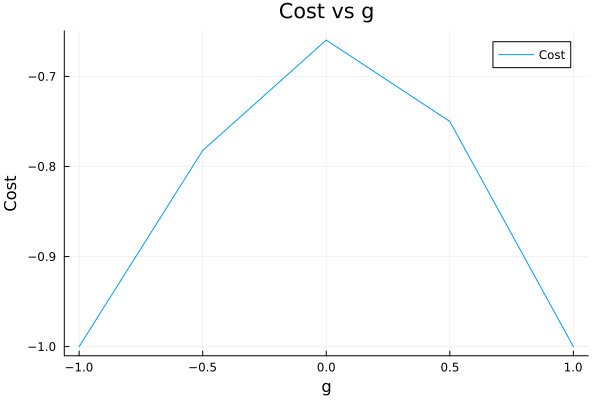

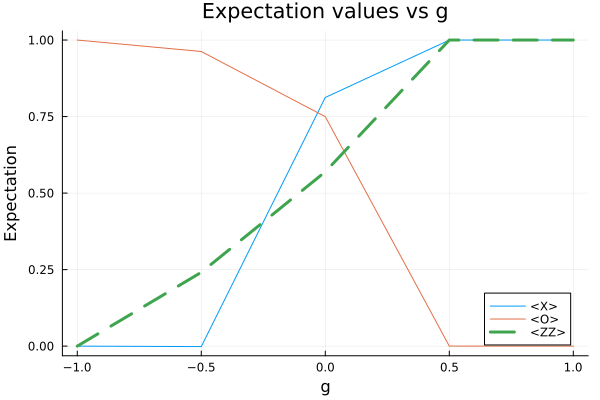

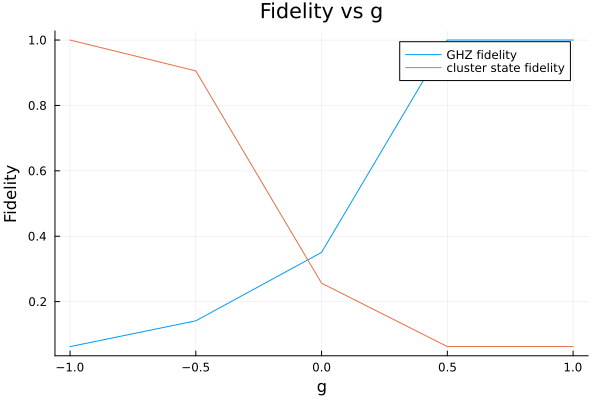

fidelity_ghz_vals = Any[0.062499999836197986, 0.1414237123687368, 0.3507590151078538, 0.9999999999999989, 0.9999999999999989]
fidelity_cluster_vals = Any[0.9999999999999997, 0.9056459186181472, 0.25642560544361753, 0.06249999999999993, 0.06249999999999993]


5-element Vector{Any}:
 0.9999999999999997
 0.9056459186181472
 0.25642560544361753
 0.06249999999999993
 0.06249999999999993

In [3]:
p1 = plot(g_values, all_costs, label="Cost", title="Cost vs g", xlabel="g", ylabel="Cost");
p2 = plot(g_values, all_X_exp, label="<X>", title="Expectation values vs g", xlabel="g", ylabel="Expectation",linewidth=1);
plot!(p2, g_values, all_O_exp, label="<O>",linewidth=1);
plot!(p2, g_values, all_ZZ_exp / (N - 1), label="<ZZ>",linestyle=:dash,linewidth=3);

p3 = plot(g_values, fidelity_ghz_vals, label="GHZ fidelity", title="Fidelity vs g", xlabel="g", ylabel="Fidelity");
plot!(p3, g_values, fidelity_cluster_vals, label="cluster state fidelity");

display(p1)
display(p2)
display(p3)

@show fidelity_ghz_vals
@show fidelity_cluster_vals

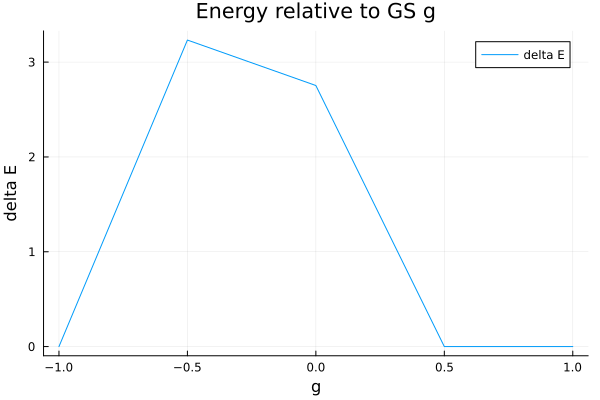

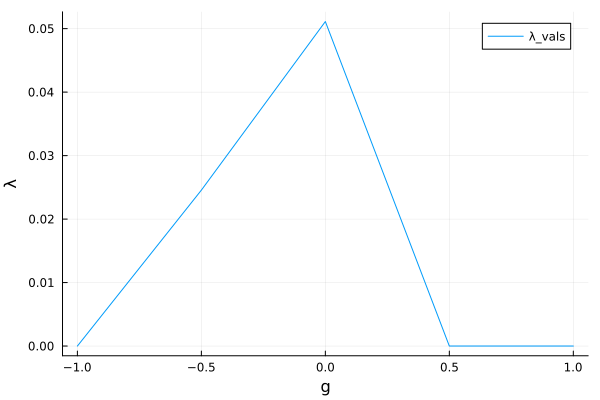

In [4]:
#Verify that the state is the GS of the learned H
pl1 = plot(g_values, delta_E_vals, label="delta E", title="Energy relative to GS g", xlabel="g", ylabel="delta E")
pl2 = plot(g_values, λ_vals, label="λ_vals", xlabel="g", ylabel="λ")

display(pl1)
display(pl2)


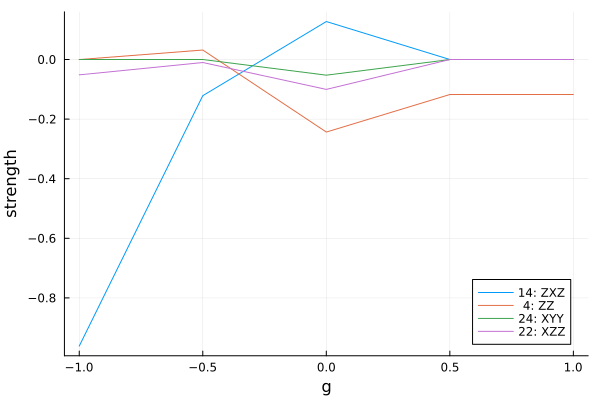

In [5]:
#Analsysis of the learned H
param4_vals = [v[4] for v in H_params]
param14_vals = [v[14] for v in H_params]
param24_vals = [v[24] for v in H_params]
param21_vals = [v[21] for v in H_params]

param22_vals = [v[22] for v in H_params]
param23_vals = [v[23] for v in H_params]

pl1 = plot(g_values, param14_vals, label="14: ZXZ", xlabel="g", ylabel="strength")
plot!(pl1, g_values, param4_vals, label=" 4: ZZ", xlabel="g", ylabel="strength")
plot!(pl1, g_values, param24_vals, label="24: XYY", xlabel="g", ylabel="strength")
plot!(pl1, g_values, param22_vals, label="22: XZZ", xlabel="g", ylabel="strength")




In [6]:
ind = 6

v = H_params[ind]

bar(1:length(v), v;
    xlabel="Index",
    ylabel="learned H",
    legend=false,
    lw=2,
    ylim=(-1.1, 1.1),
    title="Hamiltonian for g = $(g_values[ind])"
    )

BoundsError: BoundsError: attempt to access 5-element Vector{Any} at index [6]

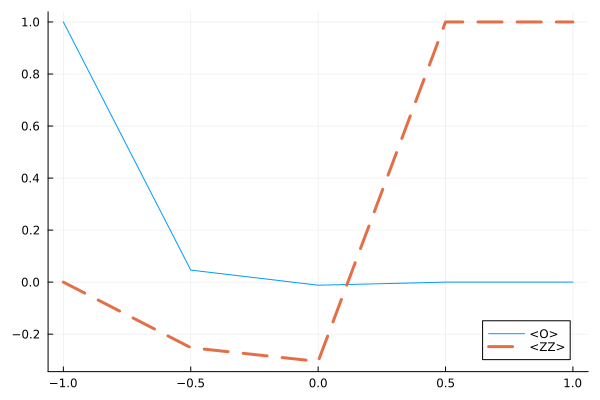

In [7]:
d = plot(g_values, all_O_HL_exp, label="<O>",linewidth=1);
plot!(d, g_values, all_ZZ_HL_exp / (N - 1), label="<ZZ>",linestyle=:dash,linewidth=3);

display(d)


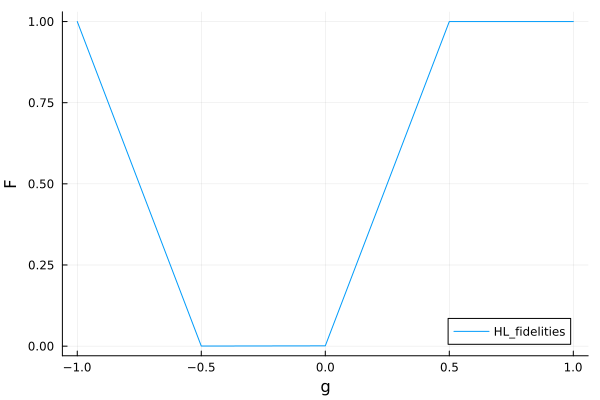

In [8]:
plot(g_values, HL_fidelities, label="HL_fidelities", xlabel="g", ylabel="F")

In [9]:
HL_fidelities

5-element Vector{Any}:
 0.9999999999999944
 0.00025461074378612633
 0.0009355334408882966
 0.9999999999999998
 0.9999999999999998

In [ ]:
using ITensors, ITensorMPS, Optim, LinearAlgebra, Printf, Random, Plots
Random.seed!(123)
include("src/QuantumResource1D.jl")
include("src/HL_module.jl")



┌ Warning: Calling `inner(x::MPS, A::MPO, y::MPS)` where the site indices of the `MPS`
│ `x` and the `MPS` resulting from contracting `MPO` `A` with `MPS` `y` don't
│ match is deprecated as of ITensors v0.3 and will result in an error in ITensors
│ v0.4. The most common cause of this is something like the following:
│ 
│ ```julia
│ s = siteinds("S=1/2")
│ psi = random_mps(s)
│ H = MPO(s, "Id")
│ inner(psi, H, psi)
│ ```
│ 
│ `psi` has the Index structure `-s-(psi)` and `H` has the Index structure
│ `-s'-(H)-s-`, so the Index structure of would be `(dag(psi)-s- -s'-(H)-s-(psi)`
│  unless the prime levels were fixed. Previously we tried fixing the prime level
│   in situations like this, but we will no longer be doing that going forward.
│ 
│ There are a few ways to fix this. You can simply change:
│ 
│ ```julia
│ inner(psi, H, psi)
│ ```
│ 
│ to:
│ 
│ ```julia
│ inner(psi', H, psi)
│ ```
│ 
│ in which case the Index structure will be `(dag(psi)-s'-(H)-s-(psi)`.
│ 
│ Alternatively, you c

real(inner(psi, qr.aux_ops[1], psi)) = 1.0347703314036335e-17
real(inner(psi, qr.aux_ops[2], psi)) = 1.0000000000000002
real(inner(psi, qr.aux_ops[3], psi)) = -1.7659319601674776e-9


-1.7659319601674776e-9

In [26]:
qr = QR1D.QuantumResource1D(N)
ind_g = 2
θ = all_params[ind_g]
psi = QR1D.apply_ladder_circuit(qr, θ)

@show real(inner(psi, qr.aux_ops[1], psi) )
@show real(inner(psi, qr.aux_ops[2], psi) )
@show real(inner(psi, qr.aux_ops[3], psi) )

@show all_X_exp[ind_g]
@show all_O_exp[ind_g]
@show all_ZZ_exp[ind_g]


hl = HL1D.HamiltonianLearner(psi)
λ_min, v_min = HL1D.LearnHamiltonian_corr_mat(hl)

real(inner(psi, qr.aux_ops[1], psi)) = -0.0015610680955136355
real(inner(psi, qr.aux_ops[2], psi)) = 0.9626184288787253
real(inner(psi, qr.aux_ops[3], psi)) = 0.9647344318458859
all_X_exp[ind_g] = -0.0015610680955136355
all_O_exp[ind_g] = 0.9626184288787253
all_ZZ_exp[ind_g] = 0.9647344318458859
Degeneracy = 1
After sweep 1 energy=-3.544900198520197  maxlinkdim=4 maxerr=3.18E-17 time=0.002
After sweep 2 energy=-3.5461295515166333  maxlinkdim=4 maxerr=5.21E-17 time=0.002
After sweep 3 energy=-3.5461437301307464  maxlinkdim=4 maxerr=7.08E-18 time=0.001
After sweep 4 energy=-3.5461439781633888  maxlinkdim=4 maxerr=7.63E-17 time=0.002
After sweep 5 energy=-3.546143982113082  maxlinkdim=4 maxerr=7.92E-18 time=0.001
After sweep 6 energy=-3.5461439821734544  maxlinkdim=4 maxerr=1.58E-16 time=0.004
After sweep 7 energy=-3.546143982174343  maxlinkdim=4 maxerr=3.85E-17 time=0.001
After sweep 8 energy=-3.5461439821743586  maxlinkdim=4 maxerr=6.60E-17 time=0.003
Fidelity = 0.00025461074378612633
G

(0.024560993002206984, [0.006098659624106727, 0.01033198699365434, -0.07183215047442404, 0.03186110213774748, -1.1069520662847392e-10, 9.151978061180761e-11, -0.5867594948862084, 0.16188711087985339, -0.07323685711859906, 1.0937925257383027e-10  …  -4.394140242899444e-11, -1.1195192415646788e-11, 0.2167702550859776, 0.12625599685660124, -1.1402660219787726e-12, 3.711778514472043e-11, 0.2625644809953919, -0.010050059828419187, -4.872777444593865e-11, 7.166778903133194e-11])

In [27]:
hl.H

MPO
[1] ((dim=5|id=820|"Link,l=1"), (dim=2|id=917|"S=1/2,Site,n=1")', (dim=2|id=917|"S=1/2,Site,n=1"))
[2] ((dim=5|id=820|"Link,l=1"), (dim=8|id=11|"Link,l=2"), (dim=2|id=520|"S=1/2,Site,n=2")', (dim=2|id=520|"S=1/2,Site,n=2"))
[3] ((dim=8|id=11|"Link,l=2"), (dim=8|id=294|"Link,l=3"), (dim=2|id=979|"S=1/2,Site,n=3")', (dim=2|id=979|"S=1/2,Site,n=3"))
[4] ((dim=8|id=294|"Link,l=3"), (dim=5|id=360|"Link,l=4"), (dim=2|id=485|"S=1/2,Site,n=4")', (dim=2|id=485|"S=1/2,Site,n=4"))
[5] ((dim=5|id=360|"Link,l=4"), (dim=2|id=801|"S=1/2,Site,n=5")', (dim=2|id=801|"S=1/2,Site,n=5"))


In [32]:
@show inner(hl.ψ_GS, hl.H, hl.ψ_GS)
@show inner(psi, hl.H, psi)
@show abs2(inner(psi, hl.ψ_GS))
@show hl.Fidelity

inner(hl.ψ_GS, hl.H, hl.ψ_GS) = -3.5461439821743603 - 1.9403663565598203e-17im
inner(psi, hl.H, psi) = -0.31371424290179906 + 5.047311380351938e-18im
abs2(inner(psi, hl.ψ_GS)) = 0.00025461074378612834
hl.Fidelity = 0.00025461074378612633


0.00025461074378612633

In [36]:
psi0 = randomMPS(hl.sites, linkdims=10)
maxdim_schedule = [10, 20, 100, 200, 400, 800, 800, 800]
sweeps = Sweeps(length(maxdim_schedule))
maxdim!(sweeps, maxdim_schedule...)
cutoff!(sweeps, 1e-10)

E0, ψ0 = dmrg(hl.H, psi0, sweeps)

@show abs2(inner(ψ0, hl.ψ_GS))
@show abs2(inner(ψ0, hl.psi))

After sweep 1 energy=-3.543870926874298  maxlinkdim=4 maxerr=0.00E+00 time=0.003
After sweep 2 energy=-3.5461171125859234  maxlinkdim=4 maxerr=1.51E-16 time=0.002
After sweep 3 energy=-3.546143568986042  maxlinkdim=4 maxerr=9.19E-17 time=0.007
After sweep 4 energy=-3.54614397636073  maxlinkdim=4 maxerr=8.73E-17 time=0.002
After sweep 5 energy=-3.5461439821001837  maxlinkdim=4 maxerr=1.71E-16 time=0.001
After sweep 6 energy=-3.5461439821735214  maxlinkdim=4 maxerr=1.24E-16 time=0.003
After sweep 7 energy=-3.546143982174348  maxlinkdim=4 maxerr=6.44E-17 time=0.001
After sweep 8 energy=-3.546143982174356  maxlinkdim=4 maxerr=2.47E-16 time=0.001
abs2(inner(ψ0, hl.ψ_GS)) = 0.9999999999999998
abs2(inner(ψ0, hl.psi)) = 0.0002546107390051464


0.0002546107390051464